# Обучение без учителя

## Оборудование (для воспроизведения замеров по времени)

In [1]:
!printf '========== OS  ==========\n'
!grep '^NAME=' /etc/os-release
!grep '^VERSION=' /etc/os-release

!printf '\n========== CPU ==========\n'
!lscpu | grep -E 'Architecture|Model name|Threads|Cores|MHz'

!printf '\n========== GPU ==========\n'
!nvidia-smi -L | grep -o 'NVIDIA .* (' | sed 's/ (//'
!nvidia-smi | grep -o 'CUDA Version: [0-9.]*'
!nvidia-smi --query-gpu=memory.total --format=csv | grep '[0-9]* MiB'

!printf '\n========== RAM ==========\n'
!free -m

========== OS  ==========
NAME="Ubuntu"
VERSION="22.04.1 LTS (Jammy Jellyfish)"

========== CPU ==========
Architecture:                    x86_64
Model name:                      Intel(R) Core(TM) i3-8130U CPU @ 2.20GHz
CPU max MHz:                     3400.0000
CPU min MHz:                     400.0000

========== GPU ==========
NVIDIA GeForce MX130
CUDA Version: 12.0
2048 MiB

========== RAM ==========
               total        used        free      shared  buff/cache   available
Mem:           11846        3647        4147         176        4050        7715
Swap:          11718           0       11718


## Решение задачи кластеризации

In [2]:
!pip install pandas==1.5.3
!pip install matplotlib==3.7.1
!pip install seaborn==0.12.2

In [3]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors

from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Собственная реализация `KMeans`

In [4]:
class MyKMeans:
    def __init__(
            self,
            n_clusters: int,
            max_iter: int = 300,
            n_init: int = 10,
            random_state=None
    ):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.n_init = n_init
        self.rng = np.random.default_rng(random_state)

    def fit_predict(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()

        def next_cluster_labels_and_centroids(centroids):
            dist_squared = ((X - centroids[:, np.newaxis]) ** 2).sum(axis=2)
            cluster_labels = np.argmin(dist_squared, axis=0)
            return cluster_labels, np.array([X[cluster_labels == k].mean(axis=0) for k in range(self.n_clusters)])

        best_silhouette = -np.inf
        best_centroids = None
        best_cluster_labels = None
        for _ in range(self.n_init):
            _, centroids = next_cluster_labels_and_centroids(self.rng.choice(X, size=self.n_clusters, replace=False))
            cluster_labels, centroids = next_cluster_labels_and_centroids(centroids)
            silhouette = silhouette_score(X, cluster_labels)
            if silhouette > best_silhouette:
                best_silhouette = silhouette
                best_centroids = centroids
                best_cluster_labels = cluster_labels

        centroids = best_centroids
        cluster_labels = best_cluster_labels

        for i in range(self.max_iter):
            new_cluster_labels, centroids = next_cluster_labels_and_centroids(centroids)
            if np.array_equal(cluster_labels, new_cluster_labels):
                return cluster_labels
            cluster_labels = new_cluster_labels
        return cluster_labels

Загрузим предобработанный в предыдущем Jupyter Notebook набор данных

In [5]:
df = pd.read_csv("normalized_prepared_place.csv")

In [6]:
df.shape

(25845, 345)

In [7]:
df.iloc[500:600]

,y,z,yaw,pitch,key_forward,key_back,key_left,key_right,key_jump,key_sneak,...,vel_y,vel_z,rel_block_x,rel_block_y,rel_block_z,yaw_sin,yaw_cos,x_frac,y_frac,z_frac
500,1.145688,3.529096,-0.941218,-0.629926,0.48963,-0.36251,-0.578754,-0.359086,1.418878,-0.291407,...,-0.211172,2.443507,-0.695018,1.122347,2.717118,0.301414,1.366987,-1.081432,-0.815943,-1.516257
501,1.322602,3.663096,-0.722507,-1.023046,0.48963,-0.36251,-0.578754,-0.359086,1.418878,-0.291407,...,1.697451,3.990478,-0.185714,0.628232,2.014749,0.449203,0.958248,1.206421,0.826940,-0.156388
502,1.462953,3.739186,-0.546323,-1.313851,0.48963,-0.36251,-0.578754,-0.359086,1.418878,-0.291407,...,1.324680,2.247347,0.123260,0.236234,1.615920,0.519451,0.607537,0.288722,2.130294,0.615790
503,1.567474,3.809935,-0.452916,-1.424251,0.48963,-0.36251,-0.578754,-0.359086,1.418878,-0.291407,...,0.959364,2.086605,-0.843001,1.120775,1.245082,0.538282,0.417164,-0.641899,-0.810717,1.333774
504,1.636881,3.875056,-0.408113,-1.440407,0.48963,-0.36251,-0.578754,-0.359086,1.418878,-0.291407,...,0.601355,1.917161,-0.525378,0.926925,0.903751,0.542720,0.325304,-1.585287,-0.166186,-1.651299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1.009410,-0.561071,-0.198559,1.347105,0.48963,-0.36251,-0.578754,2.784741,-0.704755,-0.291407,...,-2.016629,-0.121338,0.514166,-2.026427,-0.324570,0.523789,-0.103866,-0.872326,1.830159,0.726871
596,0.792762,-0.570958,-0.180334,1.457496,0.48963,-0.36251,-0.578754,2.784741,-0.704755,-0.291407,...,-2.315119,-0.340602,0.829819,-1.421336,-0.272745,0.519065,-0.140833,-1.809865,-0.181707,0.626531
597,0.303240,-0.747084,0.023187,0.547388,0.48963,-0.36251,-0.578754,2.784741,-0.704755,-0.291407,...,-0.106280,-2.319680,-0.505598,-1.230583,-1.232686,0.433518,-0.544391,-1.644036,-0.815943,-1.160842
598,0.303240,-0.830755,-0.008707,0.536618,0.48963,-0.36251,-0.578754,-0.359086,-0.704755,-0.291407,...,-0.106280,-2.561491,-0.291270,-1.230583,-0.794125,0.450843,-0.482558,1.519939,-0.815943,1.635984


In [8]:
X = df.drop(["will_place"], axis=1)
y = df["will_place"]

Инициализируем массивы для заполнения результатами экспериментов

In [9]:
silhouettes = []
calinski_harabasz_scores = []
davies_bouldin_scores = []
tune_times = []
train_times = []
model_names = []
component_nums = []
param_names = []
best_param_values = []
n_clusters = []

Вспомогательная функция для создания таблицы с результатами

In [10]:
def create_results_df():
    return pd.DataFrame({
        'Model': model_names,
        '#components': component_nums,
        '#clusters': n_clusters,
        'Silhouette': [f'{x:.4f}' for x in silhouettes],
        'Calinski-Harabasz score': [f'{x:.0f}' for x in calinski_harabasz_scores],
        'Davies-Bouldin score': [f'{x:.4f}' for x in davies_bouldin_scores],
        'Tune time, sec': [f'{x:.0f}' for x in tune_times],
        'Train time, sec': [f'{x:.1f}' for x in train_times],
        'Param name': param_names,
        'Best param value': best_param_values,
    }).sort_values(by=["Silhouette"], ascending=False)

Вспомогательные функции для оценки моделей, сохранения результатов и построения графиков

In [11]:
def eval_model(model_name, reduced_X, model_factory, param_name, param_values):
    time_before_tune = time.time()
    silhouette_scores = []
    for param_value in param_values:
        model = model_factory(param_value)
        cluster_labels = model.fit_predict(reduced_X)
        num_clusters = 1 + np.max(cluster_labels)
        cur_silhouette = silhouette_score(X, cluster_labels) if num_clusters > 1 else 0.0
        silhouette_scores.append(cur_silhouette)
    tune_time = time.time() - time_before_tune

    # plot silhouette score against {param_name}
    fig = plt.figure(figsize=(6, 6))
    plt.subplot(1, 1, 1)
    plt.title(f"{model_name}, {reduced_X.shape[1]} components")
    plt.plot(param_values, silhouette_scores, "b-")
    plt.xlabel(param_name)
    plt.ylabel("Silhouette Score")
    fig.tight_layout()
    plt.show()

    max_silhouette = max(silhouette_scores)
    best_param_value = param_values[silhouette_scores.index(max_silhouette)]

    time_before_train = time.time()
    model = model_factory(best_param_value)
    cluster_labels = model.fit_predict(reduced_X)
    train_time = time.time() - time_before_train

    num_clusters = 1 + np.max(cluster_labels)
    silhouettes.append(max_silhouette)
    calinski_harabasz_scores.append(calinski_harabasz_score(X, cluster_labels) if num_clusters > 1 else 0.0)
    davies_bouldin_scores.append(davies_bouldin_score(X, cluster_labels) if num_clusters > 1 else 0.0)
    tune_times.append(tune_time)
    train_times.append(train_time)
    model_names.append(model_name)
    component_nums.append(reduced_X.shape[1])
    param_names.append(param_name)
    best_param_values.append(best_param_value)
    n_clusters.append(num_clusters)

In [12]:
param_vals = [2, 3, 4, 6, 8, 10, 15, 20, 30, 50]

Среди реализаций из sklearn были выбраны `KMeans` и `DBSCAN`, так как для `AffinityPropagation` не хватило памяти.

In [13]:
def eval_all_models(reduced_X):
    eval_model("KMeans", reduced_X, lambda n: KMeans(n, n_init=10, random_state=0), "n_clusters", param_vals)
    eval_model("DBSCAN", reduced_X, lambda m: DBSCAN(min_samples=m), "min_samples", param_vals)
    eval_model("MyKMeans", reduced_X, lambda n: MyKMeans(n, n_init=10, random_state=0), "n_clusters", param_vals)

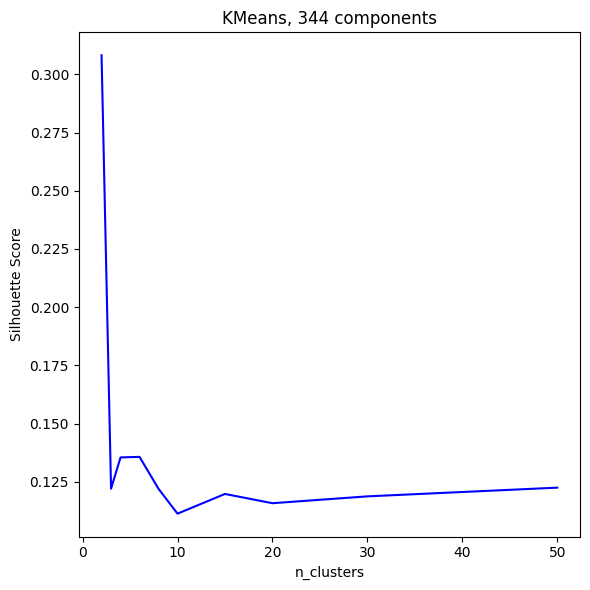

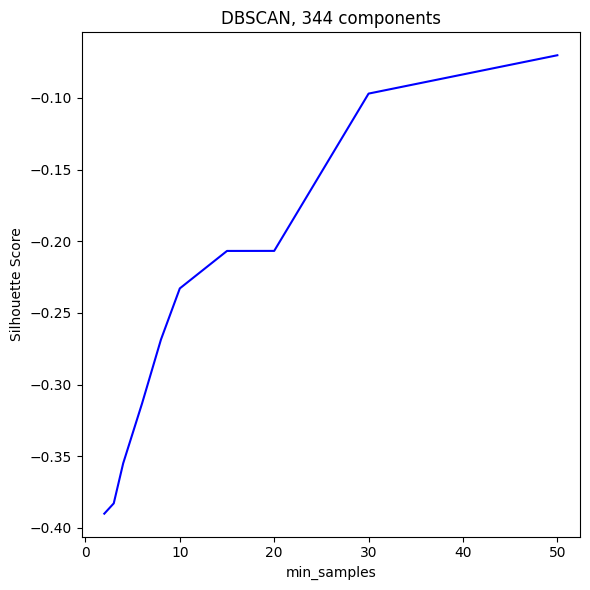

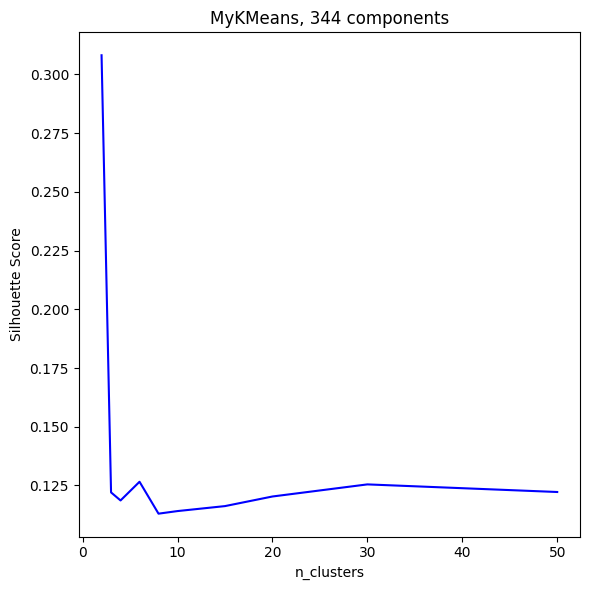

In [14]:
eval_all_models(X)

Результаты без использования PCA

In [15]:
create_results_df()

,Model,#components,#clusters,Silhouette,Calinski-Harabasz score,Davies-Bouldin score,"Tune time, sec","Train time, sec",Param name,Best param value
0,KMeans,344,2,0.3082,6723,1.2402,213,1.3,n_clusters,2
2,MyKMeans,344,2,0.3082,6723,1.2402,1379,103.6,n_clusters,2
1,DBSCAN,344,4,-0.0702,207,0.9429,184,7.9,min_samples,50


Выбор числа главных компонент, объясняющих соответственно 50%, 70%, 90% и 97% вариации

In [16]:
time_before_pca = time.time()
pca = PCA(random_state=0).fit(X)
print("PCA time:", time.time() - time_before_pca)

PCA time: 0.9102442264556885


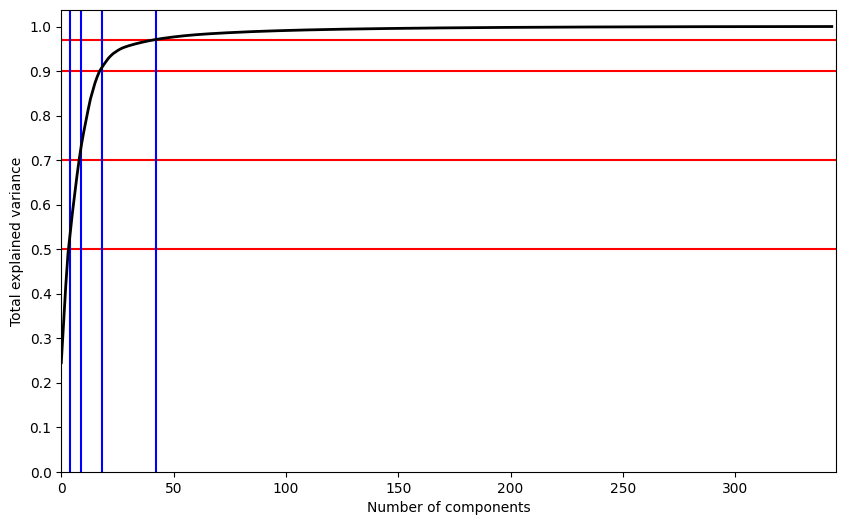

In [17]:
plt.figure(figsize=(10,6))
plt.axhline(0.5, c='r')
plt.axhline(0.7, c='r')
plt.axhline(0.9, c='r')
plt.axhline(0.97, c='r')
plt.axvline(4, c='b')
plt.axvline(9, c='b')
plt.axvline(18, c='b')
plt.axvline(42, c='b')
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 345)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show();

Замеры для выбранных количеств главных компонент

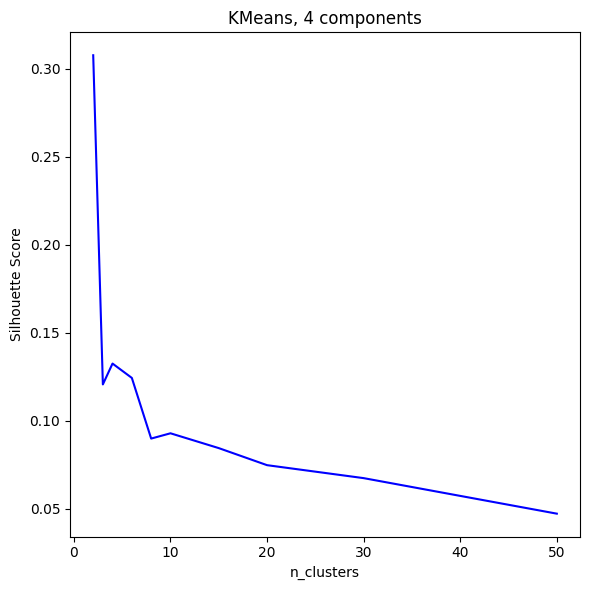

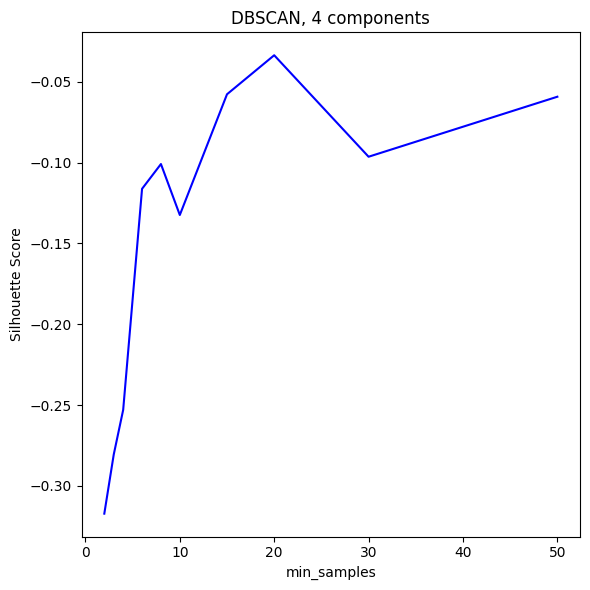

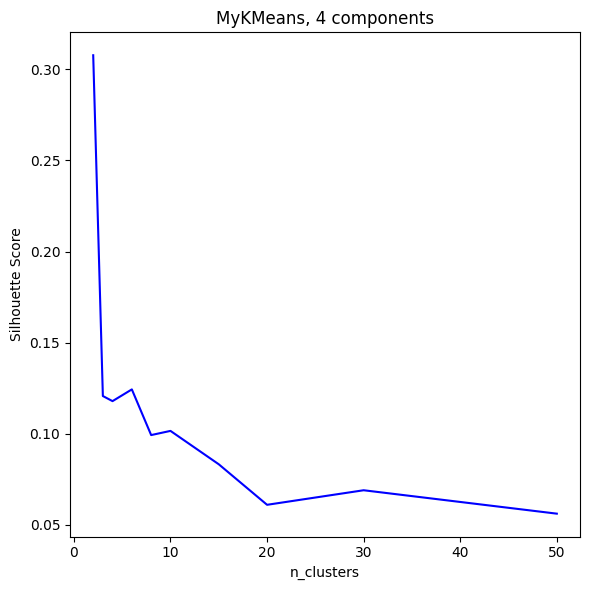

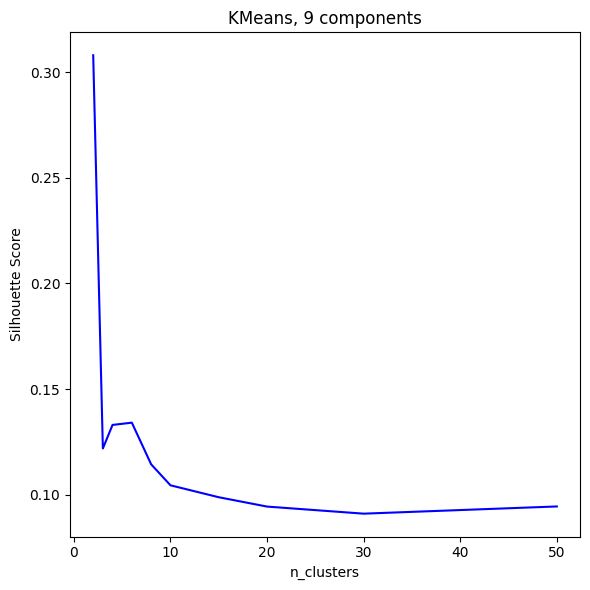

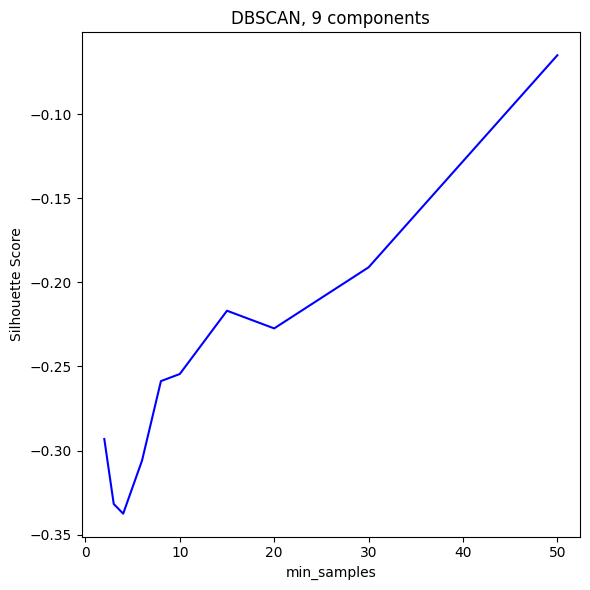

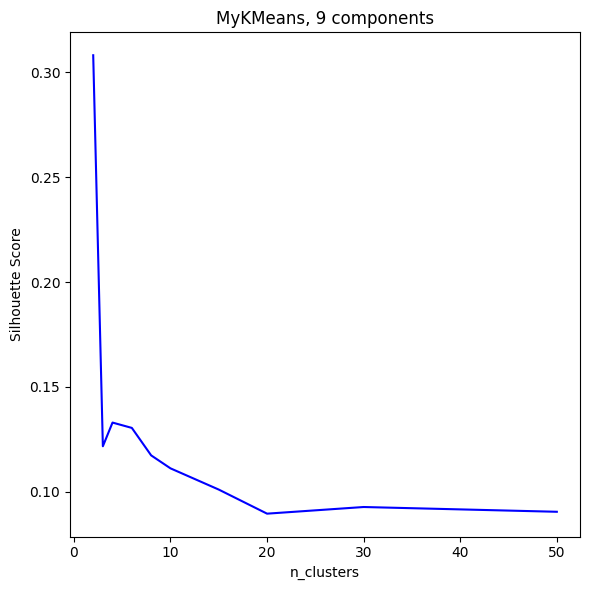

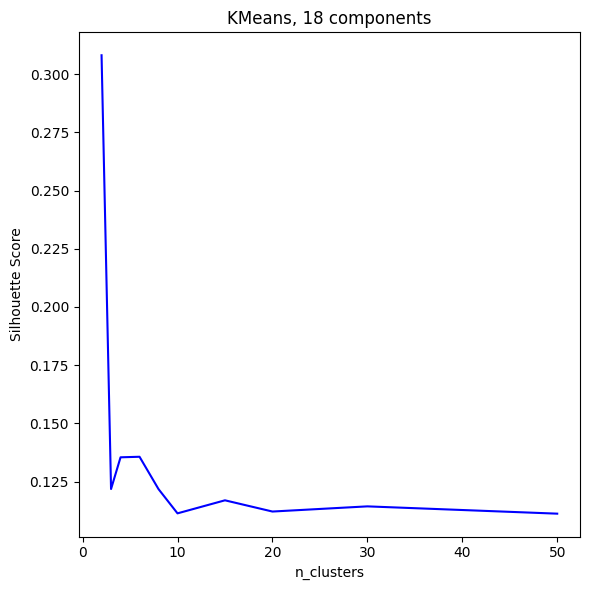

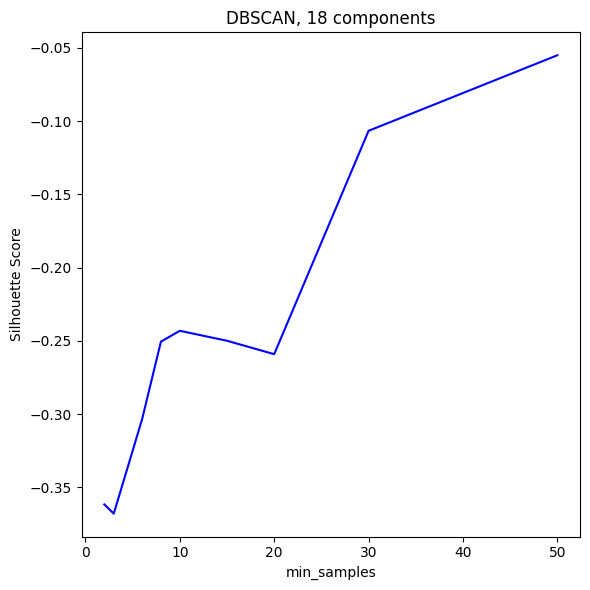

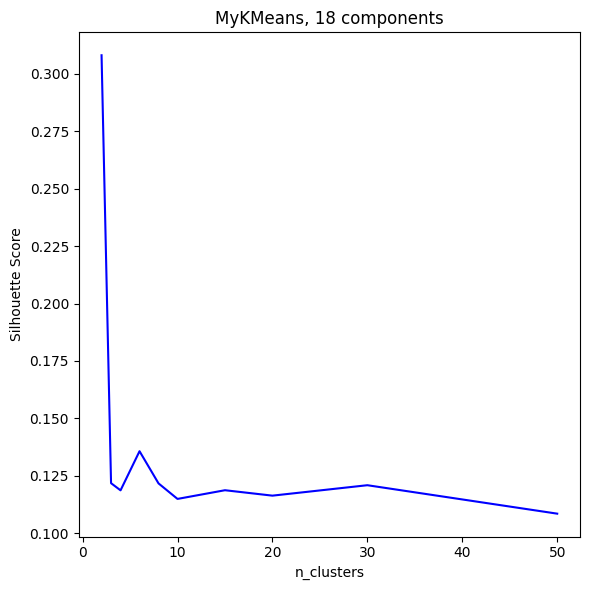

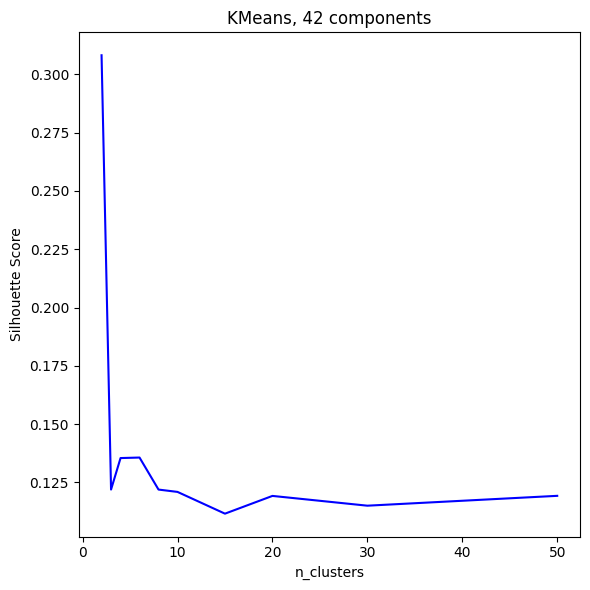

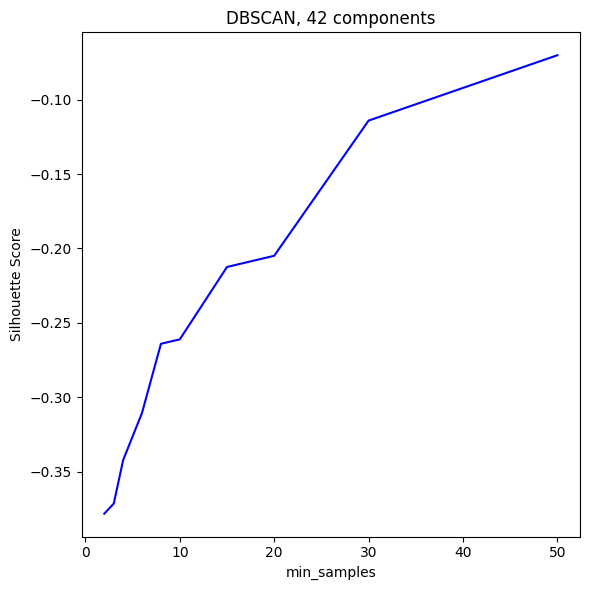

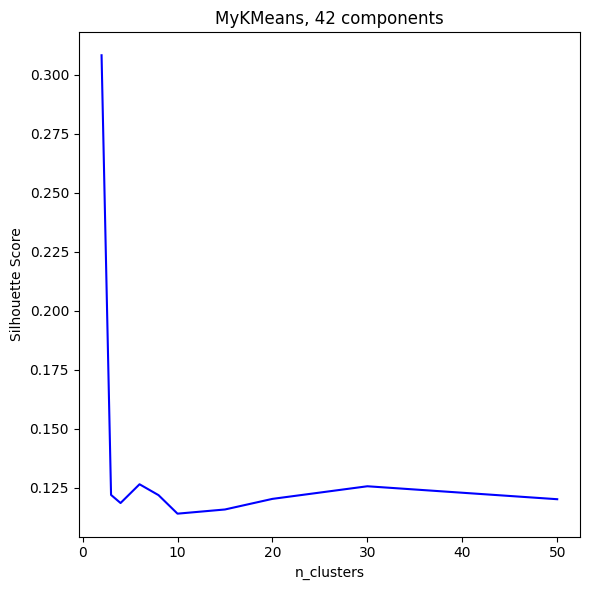

In [18]:
for n_components in [4, 9, 18, 42]:
    pca = PCA(n_components=n_components, random_state=0)
    eval_all_models(pca.fit_transform(X))

Результаты для различного количества главных компонент отличаются незначительно, лучший результат показал метод `KMeans` при разделении исходных данных на два кластера.

In [19]:
create_results_df()

,Model,#components,#clusters,Silhouette,Calinski-Harabasz score,Davies-Bouldin score,"Tune time, sec","Train time, sec",Param name,Best param value
0,KMeans,344,2,0.3082,6723,1.2402,213,1.3,n_clusters,2
2,MyKMeans,344,2,0.3082,6723,1.2402,1379,103.6,n_clusters,2
12,KMeans,42,2,0.3082,6723,1.2402,106,0.2,n_clusters,2
14,MyKMeans,42,2,0.3082,6723,1.2402,645,56.0,n_clusters,2
8,MyKMeans,9,2,0.3081,6721,1.2364,601,54.0,n_clusters,2
9,KMeans,18,2,0.3081,6723,1.2407,102,0.1,n_clusters,2
11,MyKMeans,18,2,0.3081,6723,1.2407,612,54.6,n_clusters,2
6,KMeans,9,2,0.3080,6721,1.2366,100,0.1,n_clusters,2
3,KMeans,4,2,0.3078,6720,1.2383,102,0.1,n_clusters,2
5,MyKMeans,4,2,0.3078,6720,1.2385,624,57.0,n_clusters,2


In [ ]:
kmeans = KMeans(n_clusters=2).fit(X)
cluster_labels = kmeans.predict(X)

Размеры кластеров.

In [21]:
print("Bridging cluster size:", len(df[cluster_labels == 0]))
print("Running cluster size:", len(df[cluster_labels == 1]))

Bridging cluster size: 3467
Running cluster size: 22378


Далее приведена таблица, показывающая средние значения признаков в обоих кластерах.

In [22]:
pd.DataFrame({
    "Bridging mean": df[cluster_labels == 0].mean(),
    "Running mean": df[cluster_labels == 1].mean()
}).sort_values(by=["Bridging mean"])

,Bridging mean,Running mean
yaw_sin,-2.419837,0.374903
key_forward,-1.831957,0.283823
yaw_cos,-1.430110,0.221565
rel_block_z,-0.639787,0.099122
y_frac,-0.435602,0.067487
...,...,...
pitch,1.327930,-0.205735
rel_block_x,1.416809,-0.219505
key_sneak,1.797152,-0.278431
yaw,2.156884,-0.334164


## Визуализация данных снижением размерности с помощью **PCA** и **t-SNE**

Для каждого метода снижения размерности были построены по два графика, на которых цветом обозначались соответственно значения целевого признака (`will_place`) и принадлежность к кластеру по результатам наилучшей кластеризации (`KMeans(n_clusters=2)`)

In [23]:
time_before_pca = time.time()
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)
print("PCA time:", time.time() - time_before_pca)

PCA time: 0.22655153274536133


In [24]:
cmap = matplotlib.colors.ListedColormap(['r', 'b'])

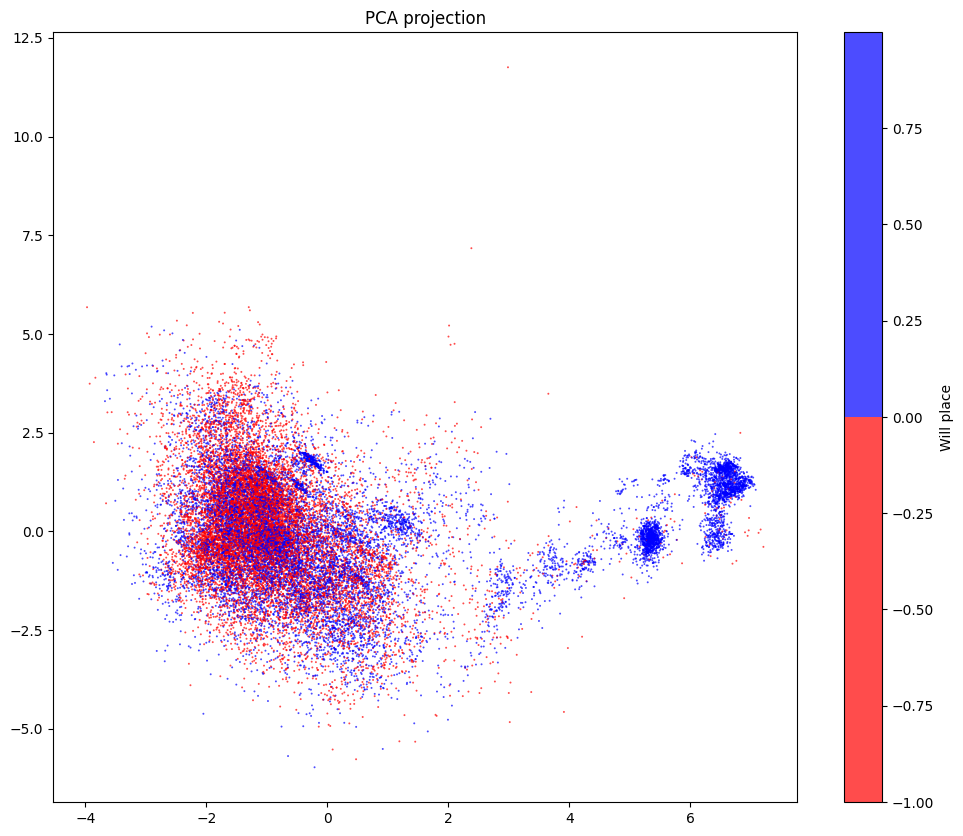

In [25]:
plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=2,
            cmap=cmap)
plt.colorbar().set_label("Will place")
plt.title('PCA projection');

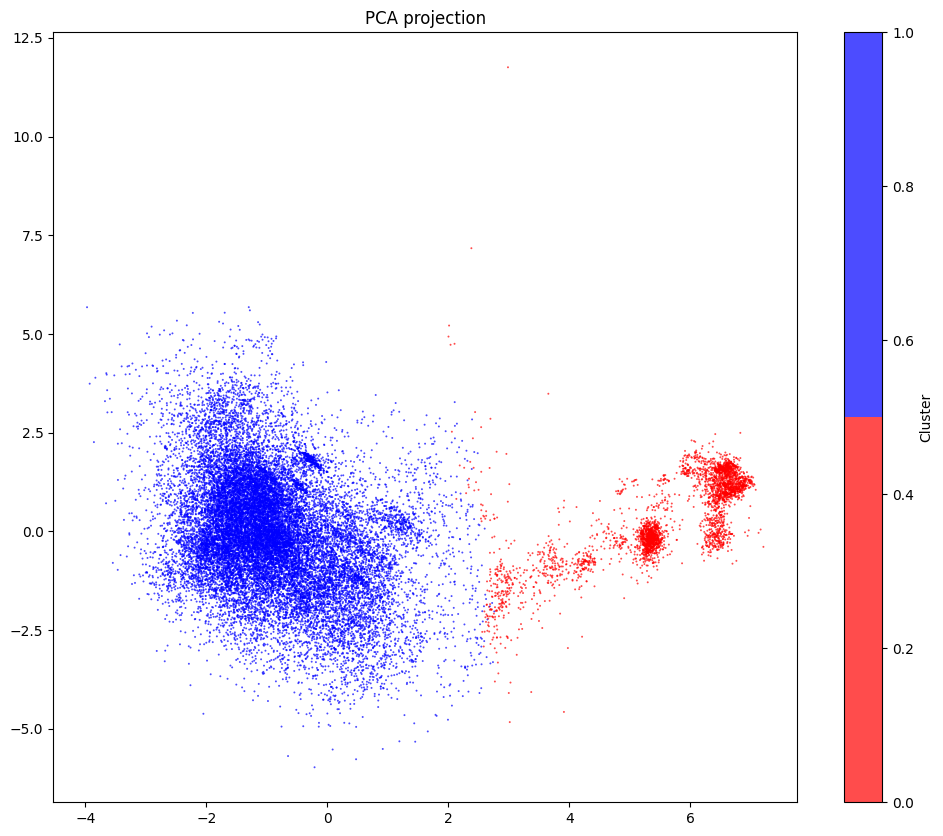

In [26]:
plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=cluster_labels,
            edgecolor='none', alpha=0.7, s=2,
            cmap=cmap)
plt.colorbar().set_label("Cluster")
plt.title('PCA projection');

In [27]:
time_before_tsne = time.time()
tsne = TSNE(random_state=0)
X_tsne = tsne.fit_transform(X)
print("TSNE time:", time.time() - time_before_tsne)

TSNE time: 122.40066909790039


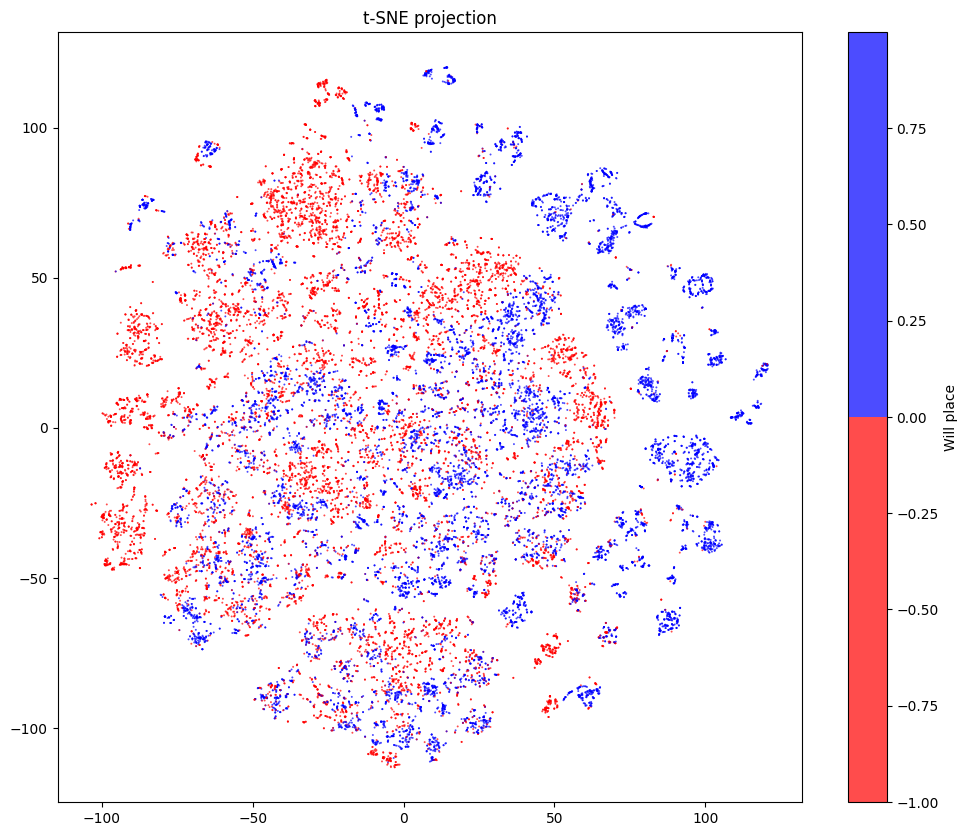

In [28]:
plt.figure(figsize=(12, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y,
    edgecolor="none", alpha=0.7, s=2,
    cmap=cmap)
plt.colorbar().set_label("Will place")
plt.title("t-SNE projection");

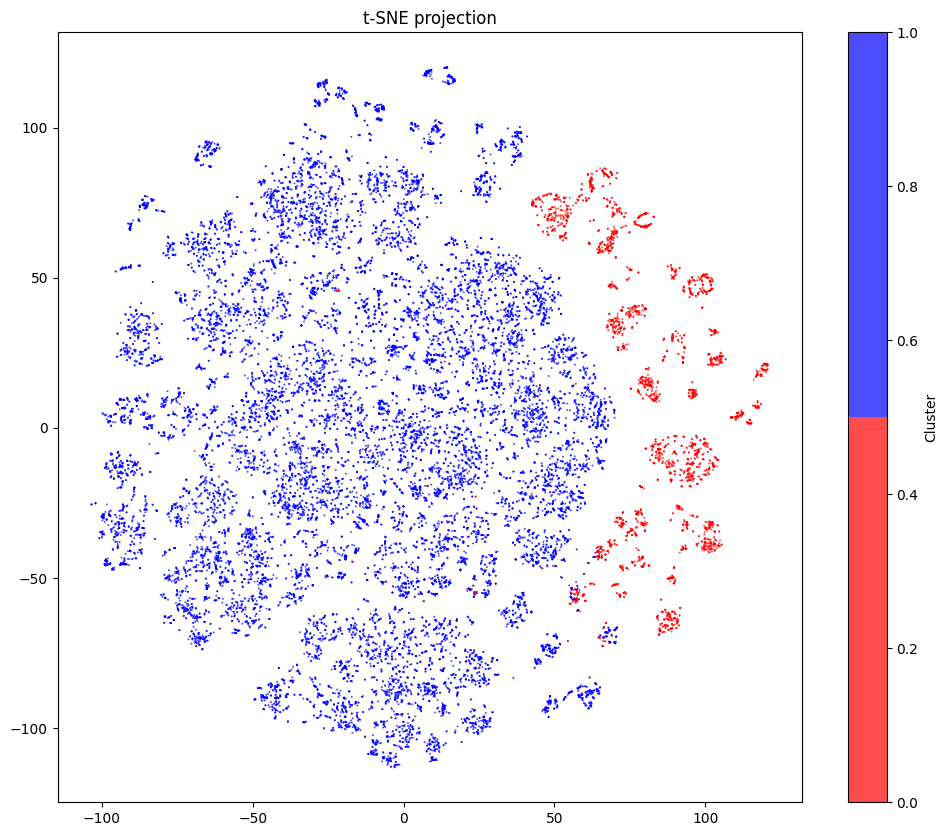

In [29]:
plt.figure(figsize=(12, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels,
    edgecolor="none", alpha=0.7, s=2,
    cmap=cmap)
plt.colorbar().set_label("Cluster")
plt.title("t-SNE projection");